In [16]:
%matplotlib notebook
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

from kalman_experiments.complex import vec2complex
from kalman_experiments.kalman import core
from kalman_experiments.kalman.core import apply_kalman_interval_smoother
from kalman_experiments.kalman.wrappers import PerturbedP1DMatsudaKF, apply_kf
from kalman_experiments.model_selection import (
    estimate_sigmas,
    fit_kf_parameters,
    get_psd_val_from_est,
    normalize_measurement_dimensions,
)
from kalman_experiments.models import (
    ArNoiseModel,
    MatsudaParams,
    SingleRhythmModel,
    gen_ar_noise_coefficients,
)
from kalman_experiments.plots import to_db

In [2]:
data_path = "../data/data.npz"

data = np.load(data_path)
data_p3 = data["P3"]
data_p4 = data["P4"]
sr = data["sampling_rate"]

data_p3 /= np.std(data_p3)
data_p4 /= np.std(data_p4)

In [3]:
# mask = data["state"] == 1
mask = data["state"] > -1
data_p3 = data_p3[mask]
data_p4 = data_p4[mask]

<IPython.core.display.Javascript object>


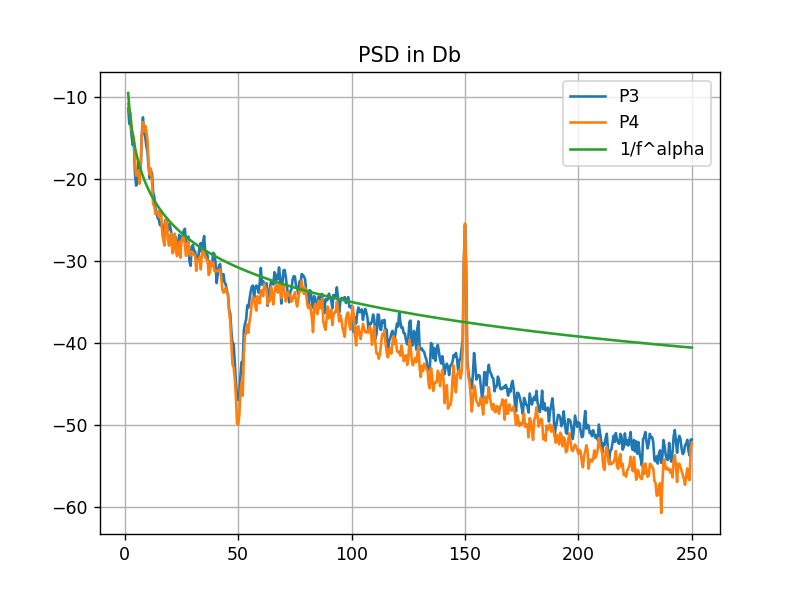

<IPython.core.display.Javascript object>


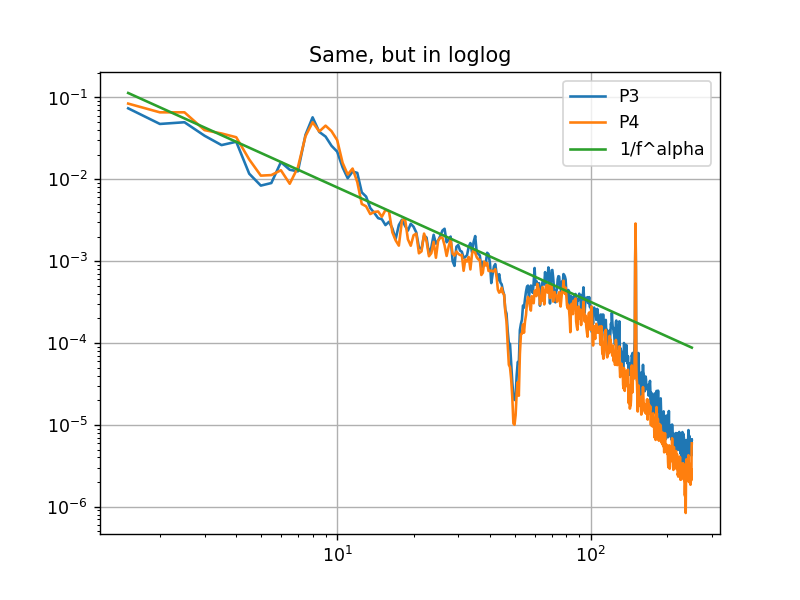

In [4]:
freq_lim = slice(3, 1000)
ff, psd_p3 = welch(data_p3[:10000], fs=sr, nperseg=1000)
ff, psd_p4 = welch(data_p4[:10000], fs=sr, nperseg=1000)
plt.figure()
plt.plot(ff[freq_lim], to_db(psd_p3[freq_lim]), label="P3")
plt.plot(ff[freq_lim], to_db(psd_p4[freq_lim]), label="P4")
alpha = 1.4
bias = 2e-1
plt.plot(ff[freq_lim], to_db([bias / f**alpha for f in ff[freq_lim]]), label="1/f^alpha")
plt.title("PSD in Db")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.loglog(ff[freq_lim], psd_p3[freq_lim], label="P3")
plt.loglog(ff[freq_lim], psd_p4[freq_lim], label="P4")
plt.loglog(ff[freq_lim], [bias / f**alpha for f in ff[freq_lim]], label="1/f^alpha")
plt.title("Same, but in loglog")
plt.legend()
plt.grid()
plt.show()

q_s=4.855074e-02, r_s=2.5906e-01


<IPython.core.display.Javascript object>


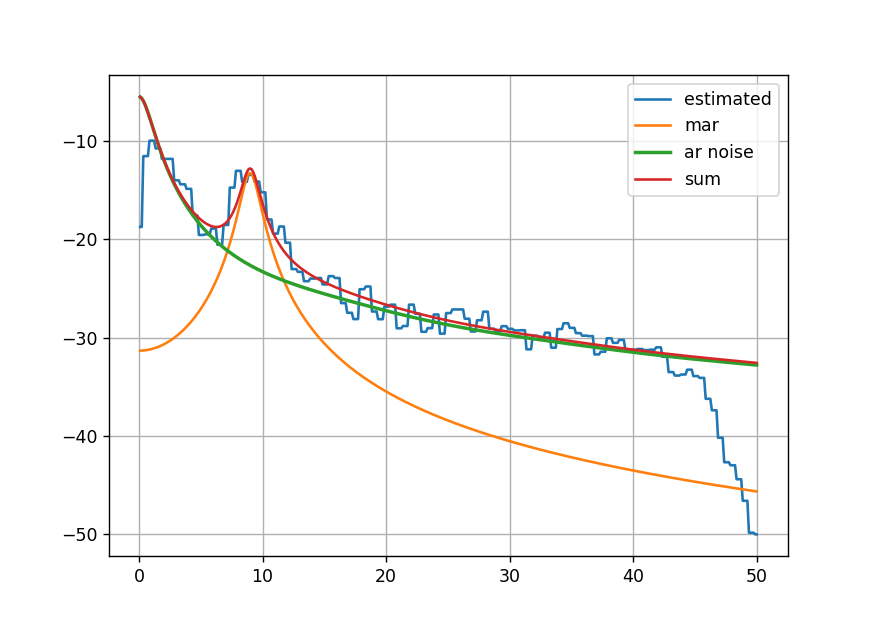

In [5]:
ar_noise_order = 30
ar_noise_model = ArNoiseModel(
    order=ar_noise_order, alpha=alpha, sr=sr, x0=np.random.randn(ar_noise_order), sigma=1
)

freq = 9
# freq = 7.49
mp = MatsudaParams(A=0.99, freq=freq, sr=sr)
# mp = MatsudaParams(A=0.9643, freq=freq, sr=sr)
mk_model = SingleRhythmModel(mp, sigma=1)

est_psd_func = partial(get_psd_val_from_est, freqs=ff, psd=psd_p4)
fit_freqs = [8, freq, 15, 40]
q_s_2, r_s_2 = estimate_sigmas(
    [mk_model.psd_onesided, ar_noise_model.psd_onesided], est_psd_func, fit_freqs
)
# q_s_2, r_s_2 = 0.1775 ** 2, 0.07 ** 2
q_s, r_s = np.sqrt(q_s_2), np.sqrt(r_s_2)
print(f"{q_s=:4e}, {r_s=:.4e}")

freqs_plt = np.linspace(0.1, 50, 400)
fig = plt.figure(figsize=(7, 5))
plt.plot(freqs_plt, [to_db(est_psd_func(f)) for f in freqs_plt], label="estimated")
plt.plot(freqs_plt, [to_db(mk_model.psd_onesided(f) * q_s_2) for f in freqs_plt], label="mar")
plt.plot(
    freqs_plt,
    [to_db(ar_noise_model.psd_onesided(f) * r_s_2) for f in freqs_plt],
    label="ar noise",
    linewidth=2,
)

plt.plot(
    freqs_plt,
    [
        to_db(mk_model.psd_onesided(f) * q_s_2 + ar_noise_model.psd_onesided(f) * r_s_2)
        for f in freqs_plt
    ],
    label="sum",
)
plt.legend()
plt.grid()
plt.show()

In [6]:
a = gen_ar_noise_coefficients(alpha=alpha, order=ar_noise_order)
kf = PerturbedP1DMatsudaKF(mp, q_s=q_s * 0.9, r_s=r_s, psi=a)


kf_fit = fit_kf_parameters(meas=data_p4[:10000], KF=kf, tol=1e-3)

Fitting KF parameters: nll=-15767.87,f=9.15, A=0.9925, 0.0476, 0.18:   1%| | 7/800 [00:1


In [7]:
all_data_p3 = data["P3"] / np.std(data["P3"])
all_data_p4 = data["P4"] / np.std(data["P4"])
kf_states = apply_kf(kf_fit, signal=all_data_p4, delay=0)
# kf_states = apply_kf(kf_fit, signal=data_p4, delay=0)

In [8]:
len(all_data_p4)

1012525

In [10]:
y = normalize_measurement_dimensions(all_data_p4)
x, P = core.apply_kf(kf_fit.KF, y)
x_n, P_n, J = apply_kalman_interval_smoother(kf_fit.KF, x, P)

In [11]:
len(x_n)

1012526

<IPython.core.display.Javascript object>


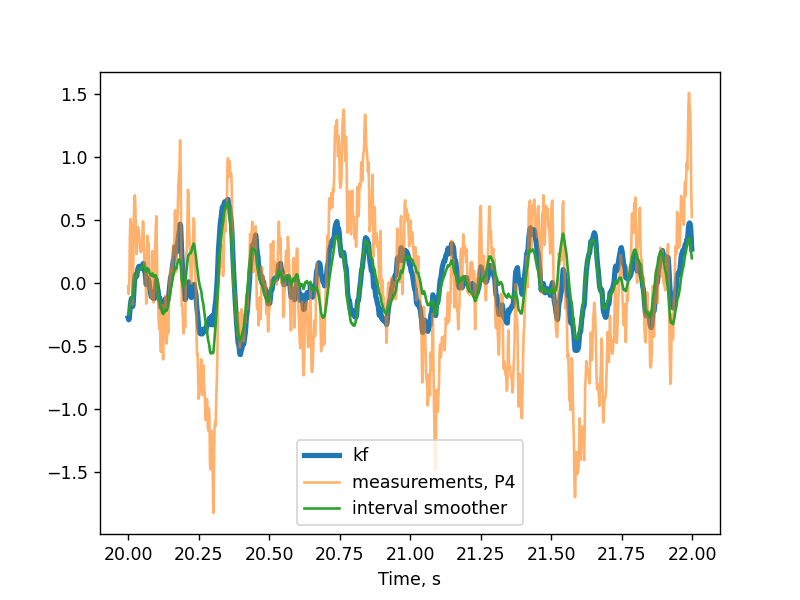

In [26]:
smoother_states = [vec2complex(x[:2]) for x in x_n[1:]]
shift = 10000
win = slice(0 + shift, 1000 + shift)
plt.figure()
times = np.arange(len(data_p4)) / sr
plt.plot(times[win], np.real(kf_states[win]), label="kf", linewidth=3)

plt.plot(times[win], all_data_p4[win], label="measurements, P4", alpha=0.6)
# plt.plot(times[win], data_p4[win], label="measurements, P4", alpha=0.6)
# plt.plot(times[win], all_data_p3[win], label="measurements, P3", alpha=0.6)
plt.plot(times[win], np.real(smoother_states)[win], label="interval smoother")
plt.legend()
plt.xlabel("Time, s")
plt.plot()
plt.show()

In [27]:

len(smoother_states)

# len(data["P3"])

1012525

In [28]:
# Save the results

# data["gt"] = smoother_states
np.savez(
    "../data/data_with_gt.npz",
    sampling_rate=sr,
    P3=data["P3"],
    P4=data["P4"],
    state=data["state"],
    gt=smoother_states,
)

In [30]:
# Check saved data

data_check = np.load("../data/data_with_gt.npz")
assert np.array_equal(data_check["gt"], smoother_states)
assert np.array_equal(data_check["P3"], data["P3"])
assert np.array_equal(data_check["P4"], data["P4"])
assert np.array_equal(data_check["state"], data["state"])
assert data_check["sampling_rate"] == data["sampling_rate"]